# SimpleGrid Environments

In [2]:
import numpy as np
from typing import List, Tuple
import gym_simplegrid
from datetime import datetime as dt
import gymnasium as gym
import matplotlib.pyplot as plt


### Environment Establishment 

In [3]:
obstacle_map = [
        "0000",
        "0101",
        "0001",
        "1000",
]
env = gym.make('SimpleGrid-4x4-v0', render_mode='rgb_array')

### Utils

In [102]:
def evaluate_policy(env, q_table, episodes=10):
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0
    # options ={
    #     'start_loc': 0,
    #     'goal_loc': 15
    # }

    for _ in range(episodes):

        state = env.reset(options={'start_loc':0, 'goal_loc':15})[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        seq = []
        counter = 0
        pass_1000 = False
        while not (done or truncated):
            action = np.argmax(q_table[state])

            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            seq.append(state)
            # if steps >10000:
            #     pass_1000 = True
            #     print("eval break")
            #     counter += 1
            #     break
        
        # if not pass_1000:
        #     print(counter)
        # print("Eval seq is ", seq)
        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length


def _plot_evaluation(rewards: List[float], lengths: List[int], title):
    # Plotting
    plt.figure(figsize=(12, 5))

    # Plot for average cumulative rewards
    plt.subplot(1, 2, 1)
    plt.plot(rewards, 'o-')  # Add 'o' marker
    plt.title("Average Cumulative Reward vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")

    # Plot for average steps
    plt.subplot(1, 2, 2)
    plt.plot(lengths, 'o-')  # Add 'o' marker
    plt.title("Average Steps vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    
    plt.tight_layout()
    plt.suptitle(title)  # Adds a title to the entire figure
    plt.show()

def universal_initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    return q_table


### Q-learning Training

In [33]:
def q_learning(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.999,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple:
    """Trains an agent using the Q-learning algorithm on a specified environment.

    This function initializes a Q-table with random values and iteratively updates it based on the agent's experiences in the environment. The exploration rate (epsilon) decreases over time, allowing the agent to transition from exploring the environment to exploiting the learned Q-values. The function periodically evaluates the agent's performance using the current Q-table and returns the training history.

    Args:
        env (gym.Env): The environment to train the agent on. Must be compatible with the OpenAI Gym interface.
        alpha (float): The learning rate, determining how much of the new Q-value estimate to use. Defaults to 0.1.
        gamma (float): The discount factor, used to balance immediate and future rewards. Defaults to 0.99.
        initial_epsilon (float): The initial exploration rate, determining how often the agent explores random actions. Defaults to 1.0.
        min_epsilon (float): The minimum exploration rate after decay. Defaults to 0.01.
        epsilon_decay (float): The factor used for exponential decay of epsilon. Defaults to 0.995.
        episodes (int): The total number of episodes to train the agent for. Defaults to 10000.
        eval_every (int): The frequency (in episodes) at which to evaluate the agent's performance. Defaults to 100.
        eval_episodes (int): The number of episodes to use for each evaluation. Defaults to 10.

    Returns:
        tuple: A tuple containing three elements:
            - np.ndarray: The final Q-table learned by the agent.
            - list: A history of average rewards obtained by the agent during evaluation periods.
            - list: A history of average step lengths taken by the agent during evaluation periods.

    """
    # Initialize Q-table
    # n_states = env.observation_space.n
    # n_actions = env.action_space.n
    # q_table = np.random.uniform(low=-0.1, high=0.1, size=(n_states, n_actions))
    # q_table[(env.desc == b"G").flatten()] = 0  # Assuming 'G' is the goal/terminal state
    q_table = universal_initialize_q_table(env)
    # options ={
    #     'start_loc': 0,
    #     'goal_loc': 15
    # }

    env.reset(options={'start_loc':0, 'goal_loc':63})
    epsilon = initial_epsilon
    rewards, lengths = [], []
    first = True

    for episode in range(episodes):
        # print(episode)
        state = env.reset( options={'start_loc':0, 'goal_loc':63})[0]
        done = env.unwrapped.done
        total_reward, steps = 0, 0
        seq = []
        while not done:
            # Epsilon-greedy action selection
            if np.random.uniform(0, 1) <= epsilon:
                action = env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(q_table[state, :])  # Exploit learned values

            next_state, reward, done, truncated, info = env.step(action)

            # Q-Learning update rule
            q_table[state, action] = q_table[state, action] + alpha * (
                reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
            )
            total_reward += reward
            # if reward == 1:
            #     print("reached the goal in state ", next_state)
            #     print("reward is ", reward, "total is ", total_reward)
            #     print("done is", done)
            # seq.append(state)
            state = next_state
            steps += 1

        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Evaluation
        print("The seq len is: ", len(seq))
        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, q_table, eval_episodes)
            if first and avg_reward == 1:
                first = False
                print("The first episode reached to 1 is ", episode)
                print("The length is  ", avg_length)
            rewards.append(avg_reward)
            lengths.append(avg_length)
            print(f"Episode: {episode + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")

    print("Training completed.")
    return q_table, rewards, lengths

The seq len is:  0
The first episode reached to 1 is  0
The length is   200.0
Episode: 1, Avg. Reward: -200.0, Avg. Length: 200.0, Epsilon: 0.999
The seq len is:  0
Episode: 2, Avg. Reward: 0.0, Avg. Length: 200.0, Epsilon: 0.998001
The seq len is:  0
Episode: 3, Avg. Reward: 0.0, Avg. Length: 200.0, Epsilon: 0.997002999
The seq len is:  0
Episode: 4, Avg. Reward: 0.0, Avg. Length: 200.0, Epsilon: 0.996005996001
The seq len is:  0
Episode: 5, Avg. Reward: 0.0, Avg. Length: 200.0, Epsilon: 0.995009990004999
The seq len is:  0
Episode: 6, Avg. Reward: 0.0, Avg. Length: 200.0, Epsilon: 0.994014980014994
The seq len is:  0
Episode: 7, Avg. Reward: 0.0, Avg. Length: 200.0, Epsilon: 0.993020965034979
The seq len is:  0
Episode: 8, Avg. Reward: 1.0, Avg. Length: 14.0, Epsilon: 0.9920279440699441
The seq len is:  0
Episode: 9, Avg. Reward: 1.0, Avg. Length: 14.0, Epsilon: 0.9910359161258742
The seq len is:  0
Episode: 10, Avg. Reward: 1.0, Avg. Length: 14.0, Epsilon: 0.9900448802097482
Trainin

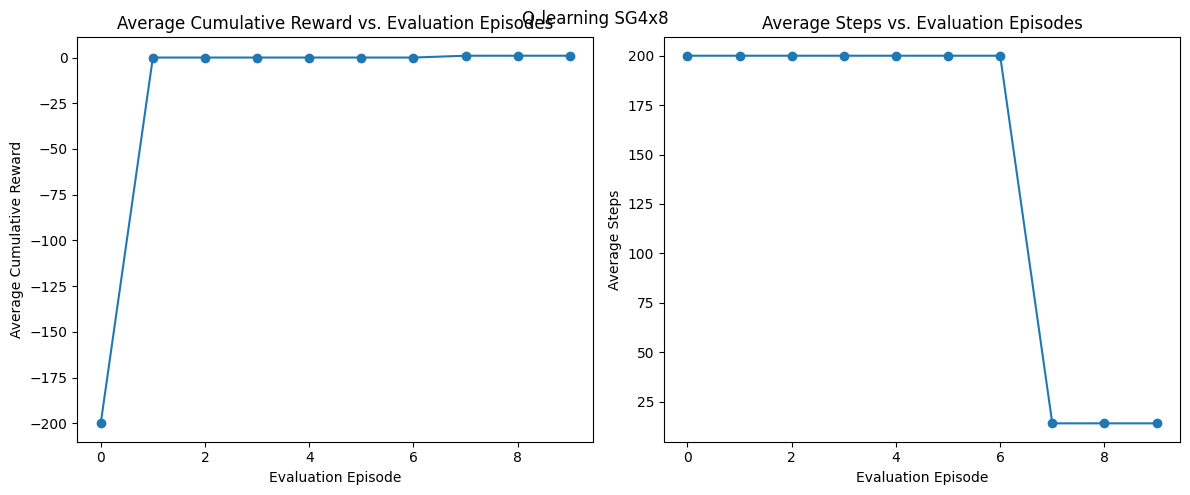

[[-9.41850263e-01  6.47340574e-11 -9.69096846e-01  5.12354265e-10]
 [-9.11370618e-01  9.94710403e-10  5.13995068e-11  4.73964886e-09]
 [-9.52898707e-01  2.35340865e-08  3.01924990e-10  1.79622032e-08]
 [-7.94108859e-01  4.45027657e-08  3.67469927e-09  9.79791383e-08]
 [-9.28210110e-01  1.33076300e-06  2.72134758e-08  2.53608228e-08]
 [-8.78423253e-01  3.77151418e-08  8.35223750e-08  3.01285232e-06]
 [-7.17564959e-01  2.67347310e-05  2.83852000e-08  3.16417002e-05]
 [-7.45789585e-01  2.25867398e-04  3.04107374e-07 -7.94080851e-01]
 [ 2.86187488e-11  1.05123924e-11 -9.01522910e-01  3.70130177e-10]
 [ 3.61678758e-10  4.72255961e-11  3.11577132e-11  2.56743069e-08]
 [ 1.56253000e-10  8.61143774e-10  4.19316480e-09  1.39506552e-07]
 [ 1.68122996e-08 -9.74968358e-01  3.12407444e-08  2.99391928e-07]
 [ 2.47445687e-08  8.05227199e-07  8.39807808e-08  1.02689248e-05]
 [ 7.65178159e-08  3.44657914e-05  4.68022817e-07  7.05569909e-06]
 [ 3.04765014e-06  2.51058843e-04  7.67853452e-08  7.86929145e

In [9]:
# obstacle_map = [
#         "10001000",
#         "10010000",
#         "00000001",
#         "01000001",
#     ]

obstable_map: [ "00000000",
                "00000000",    
                "00010000",
                "00000100",    
                "00010000",
                "01100010",    
                "01001010",
                "00010000"] # type: ignore

env = gym.make('SimpleGrid-8x8-v0', render_mode='rgb_array')

q_table, rewards, lengths = q_learning(env, episodes=10, eval_episodes=1, eval_every=1)
_plot_evaluation(rewards, lengths, title="Q-learning SG8x8")
print(q_table)

### DQL

In [109]:
def train_double_q_learning(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 0.999,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.9999,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple[np.ndarray, np.ndarray, List[float], List[int]]:
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        eval_every (int): Frequency of evaluation phases during training.
        eval_episodes (int): Number of episodes to run during each evaluation phase.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float], List[int]]: A tuple containing:
            - The final Q-table A learned by the agent.
            - The final Q-table B learned by the agent.
            - A history of average rewards obtained during evaluation periods.
            - A history of average step lengths taken during evaluation periods.
    """

    q_table_a = universal_initialize_q_table(env)
    q_table_b = universal_initialize_q_table(env)

    epsilon = initial_epsilon
    rewards, lengths = [], []
    env.reset(seed=1234, options={'start_loc':0, 'goal_loc':63})
    max_steps = 1000
    first = True
    
    for episode in range(1, episodes+1):
        state = env.reset(options={'start_loc':0, 'goal_loc':63})[0]
        done = False
        total_reward, steps = 0, 0
        
        seq = []

        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table_a[state, :] + q_table_b[state, :])

            next_state, reward, done, _, _ = env.step(action)
            if np.random.rand() < 0.5:
                best_next_action = np.argmax(q_table_a[next_state, :])
                td_target = reward + gamma * q_table_b[next_state, best_next_action]
                q_table_a[state, action] += alpha * (
                    td_target - q_table_a[state, action]
                )
            else:
                best_next_action = np.argmax(q_table_b[next_state, :])
                td_target = reward + gamma * q_table_a[next_state, best_next_action]
                q_table_b[state, action] += alpha * (
                    td_target - q_table_b[state, action]
                )
            total_reward += reward
            steps += 1
            state = next_state
            seq.append(state)
            # # If done (if we're dead) : finish episode
            # if done:
            #     break
            # if reward == 1:
            #     print("HOORAY WE GOT THERE!!!")
            
        epsilon = max(min_epsilon, epsilon_decay * epsilon)
        # print(len(seq))
        if (episode) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(
                env, q_table_a, eval_episodes
            )
            if first and avg_reward == 1:
                first = False
                print(f"Total time step: {episode + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")

            rewards.append(avg_reward)
            lengths.append(avg_length)

    print("Double Q-learning training completed.")
    return q_table_a, q_table_b, rewards, lengths


In [110]:
# obstacle_map = [
#         "10001000",
#         "10010000",
#         "00000001",
#         "01000001",
#     ]

obstable_map: [ "00000000",
                "00000000",    
                "00010000",
                "00000100",    
                "00010000",
                "01100010",    
                "01001010",
                "00010000"] # type: ignore

env = gym.make('SimpleGrid-8x8-v0', render_mode='rgb_array')

q_table_a, q_table_b, rewards, lengths = train_double_q_learning(env, episodes=1000, eval_episodes=1, eval_every=100)
_plot_evaluation(rewards, lengths, title="DQL SG8x8")
print(q_table_a)
print(q_table_b)

KeyboardInterrupt: 

### SQL

In [111]:
def epsilon_greedy_policy(Q, state, epsilon, env):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state, :])

def asynchronous_speedy_q_learning(
        env, alpha=1, epsilon=1.0, gamma=0.99, total_time_steps=10000,
        eval_every: int = 100,
        eval_episodes: int = 10,
        epsilon_decay=0.99999,
        min_epsilon = 0.1
):
    Q_k = universal_initialize_q_table(env)
    Q_k_minus_1 = np.copy(Q_k)

    state_space = env.observation_space.n
    action_space = env.action_space.n
    t = k = 0  # Iteration counter
    N = np.zeros((state_space, action_space), dtype=int)

    state = env.reset(seed=1234, options={'start_loc':0, 'goal_loc':15})[0]
    rewards, lengths, epsilons = [], [], []

    # lake_map=env.desc
    # frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())
    # print(frozen_lake_binary)
    # hole_indeces = np.where(frozen_lake_binary==0)[0]
    first = True
    # hole_indeces = [19,29,35,41,42,46,49,52,54,59]
    hole_indeces = [5,7,11,12]
    # print(hole_indeces)
    while t <= total_time_steps:
        action = epsilon_greedy_policy(Q_k, state, epsilon, env)
        next_state, reward, done, _, _ = env.step(action)
        
        eta = 1 / (N[state][action] + 1)

        # Compute temporal differences
        best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state, :])
        best_next_action_k = np.argmax(Q_k[next_state, :])
        T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
        T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (reward + gamma * Q_k[next_state, best_next_action_k])

        # Update Q_k+1
        Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k-1) * T_kQ_k_minus_1) # Update rule

        # Update Q-table references
        Q_k_minus_1 = np.copy(Q_k)
        Q_k[state, action] = np.copy(Q_k_plus_1)

        # Move to next state
        N[state][action] += 1
        # print( N[state][action])
        state = next_state

        # Check if all state-action pairs have been visited
        if np.min(N[hole_indeces]) > 0:
            print("N got reset")
            k += 1
            alpha = 1 / (k + 1)
            N = np.zeros_like(N)  # Reset visit counts

            # check kon ke satisfy shode ya na
            # another function to find a subset to be greater than the number of possible accessible state

        t += 1

        epsilon = max(min_epsilon, epsilon_decay * epsilon)

        if done:
            state = env.reset(options={'start_loc':0, 'goal_loc':15})[0]

        if (t + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_k, eval_episodes)
            if first and avg_reward == 1:
                first = False
                print(f"Total time step: {t + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")
            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)

    return Q_k, rewards, lengths


Total time step: 500, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.9950224045412736


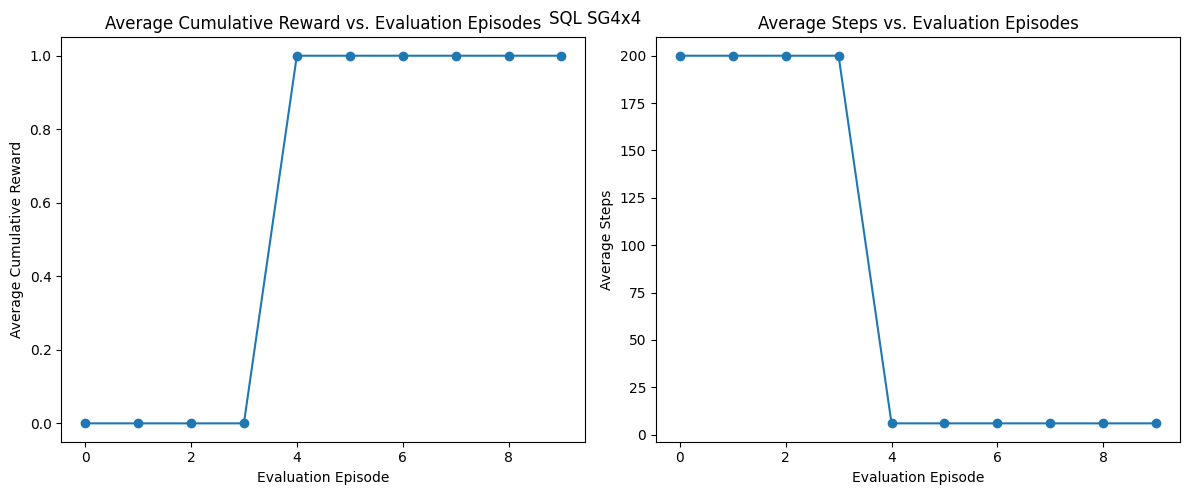

[[-0.98782323  0.06184098 -0.99019848  0.01241439]
 [-0.99220816 -0.94376384  0.00809443  0.03963183]
 [-0.94536995  0.15085065  0.01040387  0.00737989]
 [-0.90345537 -0.99782205  0.03904582 -0.99262893]
 [ 0.01669743  0.30061854 -0.86906837 -0.85112162]
 [ 0.          0.          0.          0.        ]
 [ 0.04257449  0.49005    -0.86369609 -0.83955302]
 [ 0.          0.          0.          0.        ]
 [ 0.13405224 -0.73882335 -0.6373574   0.54963075]
 [-0.53921007  0.21233415  0.23787028  0.88209   ]
 [ 0.17438725  0.99        0.5016741  -0.41194   ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.48577519 -0.86470383 -0.84782759  0.495     ]
 [ 0.6534     -0.01        0.19893496  1.        ]
 [ 0.          0.          0.          0.        ]]


In [112]:
obstacle_map = ["0000", 
                "0101", 
                "0001", 
                "1000"]



# obstable_map: [ "00000000",
#                 "00000000",    
#                 "00010000",
#                 "00000100",    
#                 "00010000",
#                 "01100010",    
#                 "01001010",
#                 "00010000"] # type: ignore

env = gym.make('SimpleGrid-4x4-v0', render_mode='rgb_array')

q_table_k, rewards, lengths = asynchronous_speedy_q_learning(env, total_time_steps=1000, eval_episodes=1, eval_every=100)
_plot_evaluation(rewards, lengths, title="SQL SG4x4")
print(q_table_k)


### QL - 4x4 - 3 Run

Training run 1
eval broke
eval broke
eval broke
The first total_time_steps reached to 1 is  4
The length is   6.0
Episode: 4, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.996005996001
Training completed.
Training run 2
eval broke
eval broke
The first total_time_steps reached to 1 is  3
The length is   6.0
Episode: 3, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.997002999
Training completed.
Training run 3
eval broke
The first total_time_steps reached to 1 is  2
The length is   6.0
Episode: 2, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.998001
Training completed.


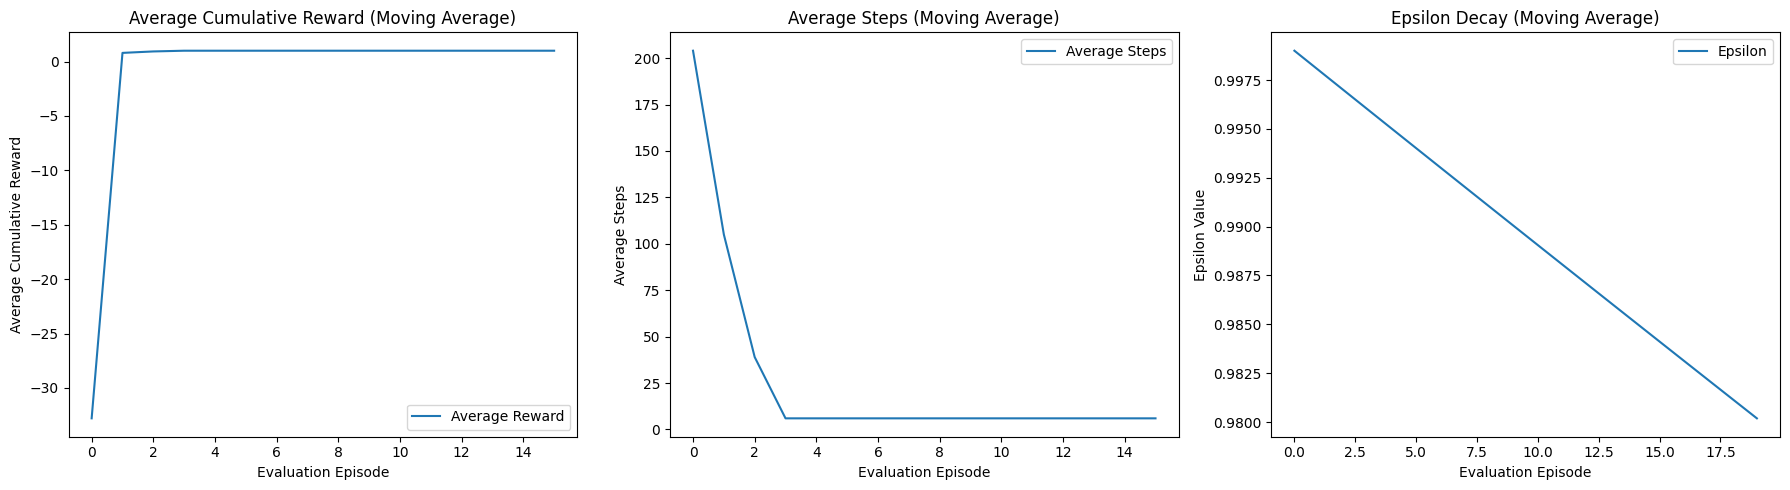

Final Q-Table:
[[-0.91495721  0.10175991 -0.89699284  0.24492127]
 [-0.69515365 -0.72546592  0.13731409  0.3680235 ]
 [-0.64032193  0.43113649  0.27363727  0.23440496]
 [-0.74226056 -0.75546111  0.35546559 -0.7481512 ]
 [ 0.07916023  0.17632698 -0.91980259 -0.93291623]
 [ 0.          0.          0.          0.        ]
 [ 0.27974647  0.53391685 -0.56549627 -0.55077404]
 [ 0.          0.          0.          0.        ]
 [ 0.04918588 -0.85775111 -0.83452976  0.36344908]
 [-0.70722534  0.36207361  0.1471993   0.57820305]
 [ 0.35901212  0.72673717  0.41187838 -0.45989529]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.26234735 -0.5773325  -0.60656999  0.56012618]
 [ 0.44228469 -0.27822206  0.2072183   0.87842335]
 [ 0.          0.          0.          0.        ]]


In [75]:
import numpy as np
from typing import List, Tuple
import gym_simplegrid
import gymnasium as gym
import matplotlib.pyplot as plt



def evaluate_policy(env, q_table, episodes=10) -> Tuple[float, float]:
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0
    options = {
        'start_loc': 0,
        'goal_loc': 15
    }

    for _ in range(episodes):
        state = env.reset(seed=1234, options=options)[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        while not (done):
            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if steps > 500:
                print("eval broke")
                break
            

        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length

def moving_average(data: List[float], window_size: int) -> List[float]:
    """Compute the moving average of a list of numbers."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def sigmoid(x):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-x))

def _plot_evaluation(rewards: List[float], lengths: List[int], epsilons: List[float], title: str, window_size: int = 10):
    """Plot the exponential moving average of rewards, lengths, and epsilon values."""
    # Calculate moving averages
    rewards_ma = moving_average(rewards, window_size)
    lengths_ma = moving_average(lengths, window_size)
    # epsilons_ma = moving_average(epsilons, window_size)

    # rewards_sig = sigmoid(rewards_ma) * 2 - 1
    # lengths_sig = sigmoid(lengths_ma) * 2 - 1
    # epsilons_sig = sigmoid(epsilons_ma) * 2 - 1

    plt.figure(figsize=(18, 5))

    # Plot for average cumulative rewards
    plt.subplot(1, 3, 1)
    plt.plot(rewards_ma, label='Average Reward')  # Add 'o' marker
    plt.title("Average Cumulative Reward (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")
    plt.legend()

    # Plot for average steps
    plt.subplot(1, 3, 2)
    plt.plot(lengths_ma, label='Average Steps')  # Add 'o' marker
    plt.title("Average Steps (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.legend()

    # Plot for epsilon changes
    plt.subplot(1, 3, 3)
    plt.plot(epsilons,  label='Epsilon')  # Add 'o' marker
    plt.title("Epsilon Decay (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)  # Adds a title to the entire figure
    plt.show()

def universal_initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    return q_table

def q_learning(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.999,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple[np.ndarray, List[float], List[float], List[float]]:
    """Trains an agent using the Q-learning algorithm on a specified environment."""
    q_table = universal_initialize_q_table(env)
    options = {
        'start_loc': 0,
        'goal_loc': 15
    }

    env.reset(seed=1234, options=options)
    epsilon = initial_epsilon
    rewards, lengths, epsilons = [], [], []
    first = True

    for episode in range(episodes):
        state = env.reset(seed=1234, options=options)[0]
        done = False
        total_reward, steps = 0, 0

        while not done:
            # Epsilon-greedy action selection
            if np.random.uniform(0, 1) <= epsilon:
                action = env.action_space.sample()  # Explore action space
            else:
                action = np.argmax(q_table[state, :])  # Exploit learned values

            next_state, reward, done, truncated, info = env.step(action)

            # Q-Learning update rule
            q_table[state, action] += alpha * (
                reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
            )
            total_reward += reward
            state = next_state
            steps += 1

        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Evaluation
        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, q_table, eval_episodes)
            if first and avg_reward == 1:
                first = False
                print("The first total_time_steps reached to 1 is ", episode+1)
                print("The length is  ", avg_length)   
                print(f"Episode: {episode + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")

            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)

    print("Training completed.")
    return q_table, rewards, lengths, epsilons

def average_results(results: List[Tuple[List[float], List[float], List[float]]], num_evals: int) -> Tuple[List[float], List[float], List[float]]:
    """Average the rewards, lengths, and epsilons across multiple training runs."""
    avg_rewards = np.zeros(num_evals)
    avg_lengths = np.zeros(num_evals)
    avg_epsilons = np.zeros(num_evals)

    for rewards, lengths, epsilons in results:
        avg_rewards += np.array(rewards)
        avg_lengths += np.array(lengths)
        avg_epsilons += np.array(epsilons)

    avg_rewards /= len(results)
    avg_lengths /= len(results)
    avg_epsilons /= len(results)

    return avg_rewards.tolist(), avg_lengths.tolist(), avg_epsilons.tolist()

if __name__ == '__main__':
    obstacle_map = [
        "0000",
        "0101",
        "0001",
        "1000",
    ]
    env = gym.make('SimpleGrid-4x4-v0', render_mode='rgb_array', obstacle_map=obstacle_map)

    num_runs = 3
    all_results = []

    for run in range(num_runs):
        print(f"Training run {run + 1}")
        q_table, rewards, lengths, epsilons = q_learning(env, episodes=20, eval_episodes=1, eval_every=1)
        all_results.append((rewards, lengths, epsilons))

    avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

    _plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="Q-learning SG4x4 (Averaged over 3 runs)", window_size=5)
    print("Final Q-Table:")
    print(q_table)


### DQL 4x4 - 3 Run

Training run 1
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
Episode: 10, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.9981012595560965
Double Q-learning training completed.
Training run 2
eval broke
eval broke
eval broke
eval broke
eval broke
Episode: 7, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.9984007498300214
Double Q-learning training completed.
Training run 3
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
eval broke
Episode: 18, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.9973030579609176
Double Q-learning training completed.


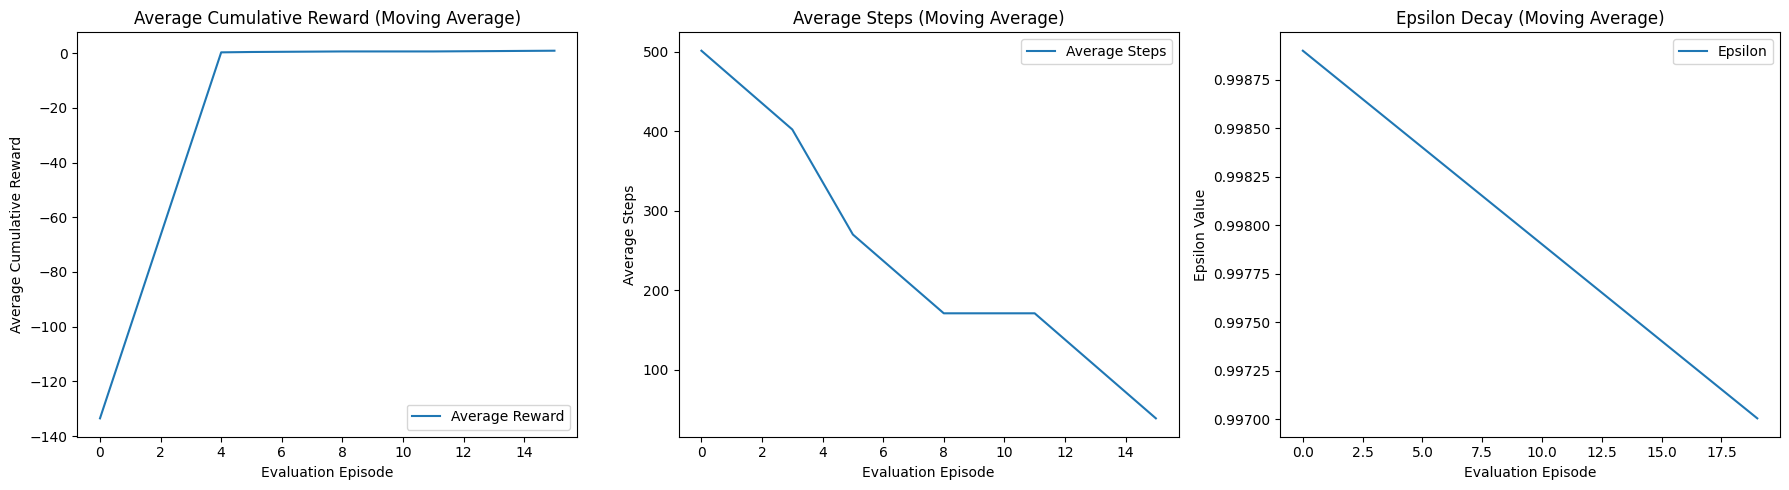

Final Q-Table:
[[-9.10282219e-01  8.86484383e-05 -9.52464813e-01  3.23029859e-03]
 [-9.00574584e-01 -8.98443373e-01  4.63878793e-04  2.14662303e-02]
 [-9.10132891e-01  1.78770256e-02  2.98500125e-03  1.90476403e-03]
 [-7.42912900e-01 -5.67562424e-01  1.07016887e-02 -8.60684178e-01]
 [ 1.11442189e-04  1.37160755e-03 -9.01339119e-01 -8.49765427e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.07102754e-02  1.00609974e-01 -7.74935696e-01 -8.53823683e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.01542974e-05 -7.72543622e-01 -9.39665676e-01  2.51171854e-02]
 [-7.75874201e-01  1.33529589e-01 -5.89098988e-03  1.13084862e-01]
 [ 1.67297422e-02  2.15799462e-01  9.47703290e-03 -6.63382814e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.12254409e-02 -5.90227966e-01 -4.91928637e-01  2.76177749e-01]
 [ 5.09480769e-02 -2.67350198e-01  4.10255982e-

In [79]:
import numpy as np
from typing import List, Tuple
import gym_simplegrid
import gymnasium as gym
import matplotlib.pyplot as plt



def evaluate_policy(env, q_table, episodes=10) -> Tuple[float, float]:
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0
    options = {
        'start_loc': 0,
        'goal_loc': 15
    }

    for _ in range(episodes):
        state = env.reset(seed=1234, options=options)[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        while not (done):
            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if steps > 500:
                print("eval broke")
                break
            

        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length

def moving_average(data: List[float], window_size: int) -> List[float]:
    """Compute the moving average of a list of numbers."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def sigmoid(x):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-x))

def _plot_evaluation(rewards: List[float], lengths: List[int], epsilons: List[float], title: str, window_size: int = 10):
    """Plot the exponential moving average of rewards, lengths, and epsilon values."""
    # Calculate moving averages
    rewards_ma = moving_average(rewards, window_size)
    lengths_ma = moving_average(lengths, window_size)
    # epsilons_ma = moving_average(epsilons, window_size)

    # rewards_sig = sigmoid(rewards_ma) * 2 - 1
    # lengths_sig = sigmoid(lengths_ma) * 2 - 1
    # epsilons_sig = sigmoid(epsilons_ma) * 2 - 1

    plt.figure(figsize=(18, 5))

    # Plot for average cumulative rewards
    plt.subplot(1, 3, 1)
    plt.plot(rewards_ma, label='Average Reward')  # Add 'o' marker
    plt.title("Average Cumulative Reward (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")
    plt.legend()

    # Plot for average steps
    plt.subplot(1, 3, 2)
    plt.plot(lengths_ma, label='Average Steps')  # Add 'o' marker
    plt.title("Average Steps (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.legend()

    # Plot for epsilon changes
    plt.subplot(1, 3, 3)
    plt.plot(epsilons,  label='Epsilon')  # Add 'o' marker
    plt.title("Epsilon Decay (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)  # Adds a title to the entire figure
    plt.show()

def universal_initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    return q_table

def train_double_q_learning(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 0.999,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.9999,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple[np.ndarray, np.ndarray, List[float], List[int]]:
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        eval_every (int): Frequency of evaluation phases during training.
        eval_episodes (int): Number of episodes to run during each evaluation phase.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float], List[int]]: A tuple containing:
            - The final Q-table A learned by the agent.
            - The final Q-table B learned by the agent.
            - A history of average rewards obtained during evaluation periods.
            - A history of average step lengths taken during evaluation periods.
    """
    # n_states = env.observation_space.n
    # n_actions = env.action_space.n
    # q_table_a = np.random.uniform(low=0, high=0.1, size=(n_states, n_actions))
    # q_table_b = np.random.uniform(low=0, high=0.1, size=(n_states, n_actions))
    # q_table_a[
    #     (env.desc == b"G").flatten()
    # ] = 0  # Assuming 'G' is the goal/terminal state
    # q_table_b[
    #     (env.desc == b"G").flatten()
    # ] = 0  # Assuming 'G' is the goal/terminal state

    q_table_a = universal_initialize_q_table(env)
    q_table_b = universal_initialize_q_table(env)

    epsilon = initial_epsilon
    rewards, lengths, epsilons = [], [], []
    env.reset(seed=1234, options={'start_loc':0, 'goal_loc':15})
    max_steps = 1000
    first = True
    
    for episode in range(1, episodes+1):
        state = env.reset(options={'start_loc':0, 'goal_loc':15})[0]
        done = False
        total_reward, steps = 0, 0
        
        seq = []

        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(q_table_a[state, :] + q_table_b[state, :])

            next_state, reward, done, truncated, info = env.step(action)
            if np.random.rand() < 0.5:
                best_next_action = np.argmax(q_table_a[next_state, :])
                td_target = reward + gamma * q_table_b[next_state, best_next_action]
                q_table_a[state, action] += alpha * (
                    td_target - q_table_a[state, action]
                )
            else:
                best_next_action = np.argmax(q_table_b[next_state, :])
                td_target = reward + gamma * q_table_a[next_state, best_next_action]
                q_table_b[state, action] += alpha * (
                    td_target - q_table_b[state, action]
                )
            total_reward += reward
            steps += 1
            state = next_state
            seq.append(state)
            # # If done (if we're dead) : finish episode
            # if done:
            #     break
            # if reward == 1:
            #     print("HOORAY WE GOT THERE!!!")
            
        epsilon = max(min_epsilon, epsilon_decay * epsilon)
        # print(len(seq))
        if (episode) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(
                env, q_table_a, eval_episodes
            )
            if first and avg_reward == 1:
                first = False
                print(f"Episode: {episode + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")

            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)

    print("Double Q-learning training completed.")
    return q_table_a, q_table_b, rewards, lengths, epsilons

def average_results(results: List[Tuple[List[float], List[float], List[float]]], num_evals: int) -> Tuple[List[float], List[float], List[float]]:
    """Average the rewards, lengths, and epsilons across multiple training runs."""
    avg_rewards = np.zeros(num_evals)
    avg_lengths = np.zeros(num_evals)
    avg_epsilons = np.zeros(num_evals)

    for rewards, lengths, epsilons in results:
        avg_rewards += np.array(rewards)
        avg_lengths += np.array(lengths)
        avg_epsilons += np.array(epsilons)

    avg_rewards /= len(results)
    avg_lengths /= len(results)
    avg_epsilons /= len(results)

    return avg_rewards.tolist(), avg_lengths.tolist(), avg_epsilons.tolist()

if __name__ == '__main__':
    obstacle_map = [
        "0000",
        "0101",
        "0001",
        "1000",
    ]
    env = gym.make('SimpleGrid-4x4-v0', render_mode='rgb_array', obstacle_map=obstacle_map)

    num_runs = 3
    all_results = []

    for run in range(num_runs):
        print(f"Training run {run + 1}")
        q_table, _, rewards, lengths, epsilons = train_double_q_learning(env, episodes=20, eval_episodes=1, eval_every=1)
        all_results.append((rewards, lengths, epsilons))

    avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

    _plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="DQL SG4x4 ", window_size=5)
    print("Final Q-Table:")
    print(q_table)


### SQL 4x4 - 3 run

Training run 1
eval broke
Total time step: 200, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.9980119688069432
Training run 2
eval broke
Total time step: 200, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.9980119688069432
Training run 3
eval broke
eval broke
Total time step: 300, Avg. Reward: 1.0, Avg. Length: 6.0, Epsilon: 0.9970144506927261


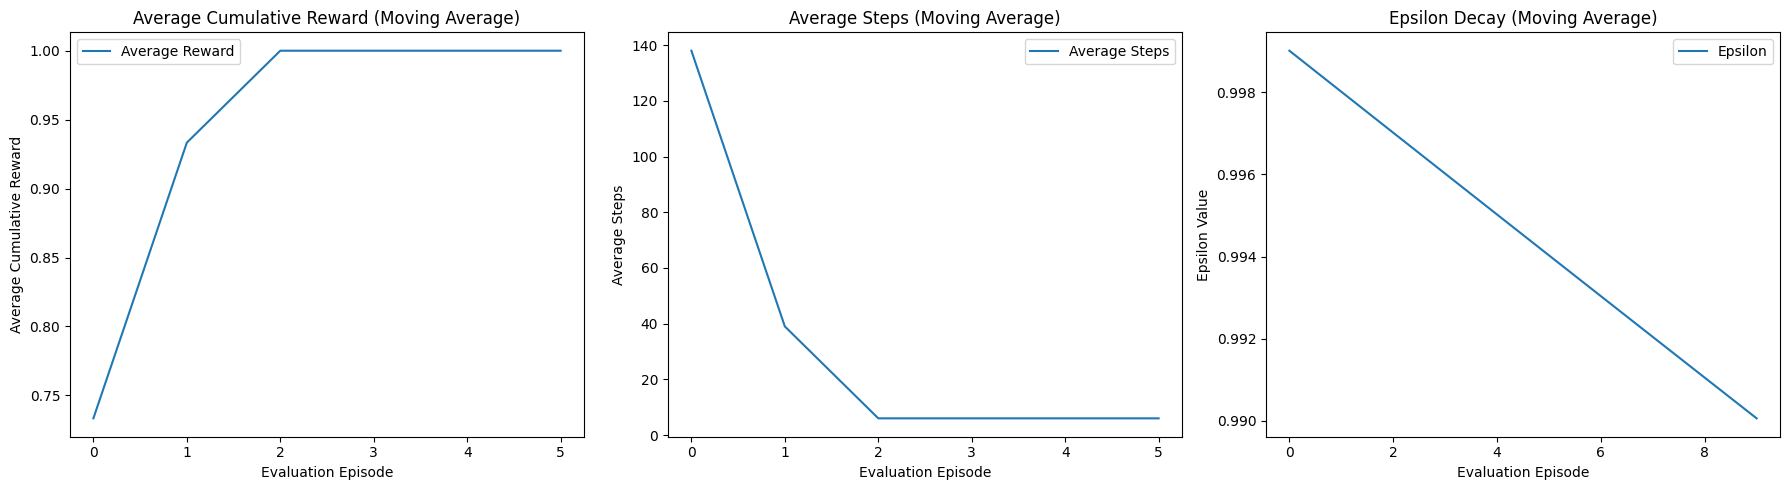

Final Q-Table:
[[-0.96755714  0.10615818 -0.91400739  0.03779904]
 [-0.97780817 -0.96639901  0.07206305  0.07625035]
 [-0.95252925  0.15509893  0.0321158   0.01696687]
 [-0.98281745 -0.98029608  0.0613407  -0.97564339]
 [ 0.03757752  0.23073852 -0.85218828 -0.90523281]
 [ 0.          0.          0.          0.        ]
 [ 0.05092906  0.51019382 -0.74229961 -0.78921214]
 [ 0.          0.          0.          0.        ]
 [ 0.10923936 -0.76261346 -0.67136668  0.44069277]
 [-0.58680351  0.67613726  0.24716693  0.55402433]
 [ 0.22062015  0.86625     0.44455066 -0.48523872]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.55289733 -0.18519437 -0.32172154  0.80909091]
 [ 0.70164044 -0.01        0.52421747  1.        ]
 [ 0.          0.          0.          0.        ]]


In [99]:
import numpy as np
from typing import List, Tuple
import gym_simplegrid
import gymnasium as gym
import matplotlib.pyplot as plt



def evaluate_policy(env, q_table, episodes=10) -> Tuple[float, float]:
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0
    options = {
        'start_loc': 0,
        'goal_loc': 15
    }

    for _ in range(episodes):
        state = env.reset(seed=1234, options=options)[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        while not (done):
            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if steps > 500:
                print("eval broke")
                break
            

        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length

def moving_average(data: List[float], window_size: int) -> List[float]:
    """Compute the moving average of a list of numbers."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def sigmoid(x):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-x))

def _plot_evaluation(rewards: List[float], lengths: List[int], epsilons: List[float], title: str, window_size: int = 10):
    """Plot the exponential moving average of rewards, lengths, and epsilon values."""
    # Calculate moving averages
    rewards_ma = moving_average(rewards, window_size)
    lengths_ma = moving_average(lengths, window_size)
    # epsilons_ma = moving_average(epsilons, window_size)

    # rewards_sig = sigmoid(rewards_ma) * 2 - 1
    # lengths_sig = sigmoid(lengths_ma) * 2 - 1
    # epsilons_sig = sigmoid(epsilons_ma) * 2 - 1

    plt.figure(figsize=(18, 5))

    # Plot for average cumulative rewards
    plt.subplot(1, 3, 1)
    plt.plot(rewards_ma, label='Average Reward')  # Add 'o' marker
    plt.title("Average Cumulative Reward (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")
    plt.legend()

    # Plot for average steps
    plt.subplot(1, 3, 2)
    plt.plot(lengths_ma, label='Average Steps')  # Add 'o' marker
    plt.title("Average Steps (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.legend()

    # Plot for epsilon changes
    plt.subplot(1, 3, 3)
    plt.plot(epsilons,  label='Epsilon')  # Add 'o' marker
    plt.title("Epsilon Decay (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)  # Adds a title to the entire figure
    plt.show()

def universal_initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    return q_table

def epsilon_greedy_policy(Q, state, epsilon, env):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state, :])

def asynchronous_speedy_q_learning(
        env, alpha=1, epsilon=1.0, gamma=0.99, total_time_steps=10000,
        eval_every: int = 100,
        eval_episodes: int = 10,
        epsilon_decay=0.99999,
        min_epsilon = 0.1
):
    Q_k = universal_initialize_q_table(env)
    Q_k_minus_1 = np.copy(Q_k)

    state_space = env.observation_space.n
    action_space = env.action_space.n
    t = k = 0  # Iteration counter
    N = np.zeros((state_space, action_space), dtype=int)

    state = env.reset(seed=1234, options={'start_loc':0, 'goal_loc':15})[0]
    rewards, lengths, epsilons = [], [], []

    # lake_map=env.desc
    # frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())
    # print(frozen_lake_binary)
    # hole_indeces = np.where(frozen_lake_binary==0)[0]
    first = True
    # hole_indeces = [19,29,35,41,42,46,49,52,54,59]
    hole_indeces = [5,7,11,12]
    # print(hole_indeces)
    while t <= total_time_steps:
        action = epsilon_greedy_policy(Q_k, state, epsilon, env)
        next_state, reward, done, _, _ = env.step(action)
        
        eta = 1 / (N[state][action] + 1)

        # Compute temporal differences
        best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state, :])
        best_next_action_k = np.argmax(Q_k[next_state, :])
        T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
        T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (reward + gamma * Q_k[next_state, best_next_action_k])

        # Update Q_k+1
        Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k-1) * T_kQ_k_minus_1) # Update rule

        # Update Q-table references
        Q_k_minus_1 = np.copy(Q_k)
        Q_k[state, action] = np.copy(Q_k_plus_1)

        # Move to next state
        N[state][action] += 1
        # print( N[state][action])
        state = next_state

        # Check if all state-action pairs have been visited
        if np.min(N[hole_indeces]) > 0:
            print("N got reset")
            k += 1
            alpha = 1 / (k + 1)
            N = np.zeros_like(N)  # Reset visit counts

            # check kon ke satisfy shode ya na
            # another function to find a subset to be greater than the number of possible accessible state

        t += 1

        epsilon = max(min_epsilon, epsilon_decay * epsilon)

        if done:
            state = env.reset(options={'start_loc':0, 'goal_loc':15})[0]

        if (t + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_k, eval_episodes)
            if first and avg_reward == 1:
                first = False
                print(f"Total time step: {t + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")
            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)

    return Q_k, rewards, lengths, epsilons

def average_results(results: List[Tuple[List[float], List[float], List[float]]], num_evals: int) -> Tuple[List[float], List[float], List[float]]:
    """Average the rewards, lengths, and epsilons across multiple training runs."""
    avg_rewards = np.zeros(num_evals)
    avg_lengths = np.zeros(num_evals)
    avg_epsilons = np.zeros(num_evals)

    for rewards, lengths, epsilons in results:
        avg_rewards += np.array(rewards)
        avg_lengths += np.array(lengths)
        avg_epsilons += np.array(epsilons)

    avg_rewards /= len(results)
    avg_lengths /= len(results)
    avg_epsilons /= len(results)

    return avg_rewards.tolist(), avg_lengths.tolist(), avg_epsilons.tolist()

if __name__ == '__main__':
    obstacle_map = [
        "0000",
        "0101",
        "0001",
        "1000",
    ]
    env = gym.make('SimpleGrid-4x4-v0', render_mode='rgb_array', obstacle_map=obstacle_map)

    num_runs = 3
    all_results = []

    for run in range(num_runs):
        print(f"Training run {run + 1}")
        q_table, rewards, lengths, epsilons = asynchronous_speedy_q_learning(env, total_time_steps=1000, eval_episodes=1, eval_every=100)
        all_results.append((rewards, lengths, epsilons))

    avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

    _plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="SQL SG4x4 (Averaged over 3 runs)", window_size=5)
    print("Final Q-Table:")
    print(q_table)


### SDQL 4x4 - 3 Run 

In [118]:
import numpy as np
from typing import List, Tuple
import gym_simplegrid
import gymnasium as gym
import matplotlib.pyplot as plt



def evaluate_policy(env, q_table, episodes=10) -> Tuple[float, float]:
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0
    options = {
        'start_loc': 0,
        'goal_loc': 15
    }

    for _ in range(episodes):
        state = env.reset(seed=1234, options=options)[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        while not (done):
            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if steps > 500:
                print("eval broke")
                break
            

        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length

def moving_average(data: List[float], window_size: int) -> List[float]:
    """Compute the moving average of a list of numbers."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def sigmoid(x):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-x))

def _plot_evaluation(rewards: List[float], lengths: List[int], epsilons: List[float], title: str, window_size: int = 10):
    """Plot the exponential moving average of rewards, lengths, and epsilon values."""
    # Calculate moving averages
    rewards_ma = moving_average(rewards, window_size)
    lengths_ma = moving_average(lengths, window_size)
    # epsilons_ma = moving_average(epsilons, window_size)

    # rewards_sig = sigmoid(rewards_ma) * 2 - 1
    # lengths_sig = sigmoid(lengths_ma) * 2 - 1
    # epsilons_sig = sigmoid(epsilons_ma) * 2 - 1

    plt.figure(figsize=(18, 5))

    # Plot for average cumulative rewards
    plt.subplot(1, 3, 1)
    plt.plot(rewards_ma, label='Average Reward')  # Add 'o' marker
    plt.title("Average Cumulative Reward (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")
    plt.legend()

    # Plot for average steps
    plt.subplot(1, 3, 2)
    plt.plot(lengths_ma, label='Average Steps')  # Add 'o' marker
    plt.title("Average Steps (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.legend()

    # Plot for epsilon changes
    plt.subplot(1, 3, 3)
    plt.plot(epsilons,  label='Epsilon')  # Add 'o' marker
    plt.title("Epsilon Decay (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)  # Adds a title to the entire figure
    plt.show()

def universal_initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    return q_table

def epsilon_greedy_policy(Q, state, epsilon, env):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state, :])

def edited_speedy_double_q_learning(env, epsilon=1, min_epsilon=0.1, epsilon_decay=0.9999, T=100000, gamma=0.99, eval_interval=50, eval_episodes=1):
    state_space = env.observation_space.n
    action_space = env.action_space.n

    Q_A = universal_initialize_q_table(env)
    Q_B = universal_initialize_q_table(env)
    Q_A_minus_1, Q_B_minus_1 = np.copy(Q_A), np.copy(Q_B)

    N_A = np.zeros((state_space, action_space))
    N_B = np.zeros((state_space, action_space))

    rewards, lengths, epsilons = [], [], []

    k_A = k_B = 0
    alpha_A = alpha_B = 1

    state = env.reset(options={'start_loc':0, 'goal_loc':15})[0]
    t = 0

    # hole_indeces = [19,29,35,41,42,46,49,52,54,59]
    hole_indeces = [5,7,11,12]
    first = True
    while t <= T:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            combined_Q = (Q_A[state, :] + Q_B[state, :]) / 2
            action = np.argmax(combined_Q)

        next_state, reward, done, truncated, info = env.step(action)

        if np.random.rand() < 0.5:  # Update Q_A
            eta = 1 / (N_A[state, action] + 1)
            a_star = np.argmax(Q_A_minus_1[next_state, :])
            a_plus = np.argmax(Q_A[next_state, :])

            T_kQ_A_minus_1 = (1 - eta) * Q_A_minus_1[state, action] + eta * (reward + gamma * Q_B_minus_1[next_state, a_star])
            T_kQ_A = (1 - eta) * Q_A[state, action] + eta * (reward + gamma * Q_B[next_state, a_plus])

            Q_A_minus_1[state, action] = Q_A[state, action]
            Q_A[state, action] = (1 - alpha_A) * Q_A[state, action] + alpha_A * (k_A * T_kQ_A - (k_A - 1) * T_kQ_A_minus_1)
            N_A[state, action] += 1
        else:  # Update Q_B
            eta = 1 / (N_B[state, action] + 1)
            a_star = np.argmax(Q_B_minus_1[next_state, :])
            a_plus = np.argmax(Q_B[next_state, :])
            T_kQ_B_minus_1 = (1 - eta) * Q_B_minus_1[state, action] + eta * (
                        reward + gamma * Q_A_minus_1[next_state, a_star])
            T_kQ_B = (1 - eta) * Q_B[state, action] + eta * (reward + gamma * Q_A[next_state, a_plus])

            Q_B_minus_1[state, action] = Q_B[state, action]
            Q_B[state, action] = (1 - alpha_B) * Q_B[state, action] + alpha_B * (
                        k_B * T_kQ_B - (k_B - 1) * T_kQ_B_minus_1)
            N_B[state, action] += 1

        state = next_state

        # Update counters and learning rates if needed
        if np.min(N_A[hole_indeces]) > 0:
            k_A += 1
            alpha_A = 1 / (k_A + 1)
            N_A.fill(0)  # Reset visit counts for A
        if np.min(N_B[hole_indeces]) > 0:
            k_B += 1
            alpha_B = 1 / (k_B + 1)
            N_B.fill(0)  # Reset visit counts for B

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Reduce epsilon
        t += 1
        if done:
            state = env.reset(options={'start_loc':0, 'goal_loc':15})[0]

        if (t + 1) % eval_interval == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_A, eval_episodes)
            if first and avg_reward:
                first = False
                print(f"Evaluation at step {t + 1}: Avg Reward = {avg_reward}, Avg Length = {avg_length}")

            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)


    return Q_A, rewards, lengths, epsilons



def average_results(results: List[Tuple[List[float], List[float], List[float]]], num_evals: int) -> Tuple[List[float], List[float], List[float]]:
    """Average the rewards, lengths, and epsilons across multiple training runs."""
    avg_rewards = np.zeros(num_evals)
    avg_lengths = np.zeros(num_evals)
    avg_epsilons = np.zeros(num_evals)

    for rewards, lengths, epsilons in results:
        avg_rewards += np.array(rewards)
        avg_lengths += np.array(lengths)
        avg_epsilons += np.array(epsilons)

    avg_rewards /= len(results)
    avg_lengths /= len(results)
    avg_epsilons /= len(results)

    return avg_rewards.tolist(), avg_lengths.tolist(), avg_epsilons.tolist()

if __name__ == '__main__':
    obstacle_map = [
        "0000",
        "0101",
        "0001",
        "1000",
    ]
    env = gym.make('SimpleGrid-4x4-v0', render_mode='rgb_array', obstacle_map=obstacle_map)

    num_runs = 3
    all_results = []

    for run in range(num_runs):
        print(f"Training run {run + 1}")
        q_table, rewards, lengths, epsilons = edited_speedy_double_q_learning(env, T=10000, eval_episodes=1, eval_interval=1000)
        all_results.append((rewards, lengths, epsilons))

    avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

    _plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="SDQL SG4x4 (Averaged over 3 runs)", window_size=5)
    print("Final Q-Table:")
    print(q_table)


Training run 1
eval broke
Evaluation at step 2000: Avg Reward = 1.0, Avg Length = 6.0
